# Team Information

Project Title: Data Analysis on the Pokémon Pokedex

Team Name: Team 6

Member Names w/ PIDs: Rohan Jaggannagari (rjaggannagari), Jayanth Kalidindi (jayk21), Luke Hylton (lnhylton), Markus Homann (homann), Aniket Sonnakul (anikets)

# Contributions

Rohan Jaggannagari: Cleaned up and merged the datasets from Kaggle, PCA analysis/clustering/distance matrix on legendary Pokemon, correlation matrix for each base stat and generation, recomendation system

Jayanth Kalidindi:

Luke Hylton:

Markus Homann:

Aniket Sonnakul:

## Imports

In [157]:
import pandas
import numpy
import IPython
import sklearn.metrics.pairwise
import sklearn.cluster
import sklearn.decomposition
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, clear_output

## Reading in data

In [32]:
# Read in the data
pokemon_data_df = pandas.read_csv('pokemon_data.csv')
pokemon_abilities_df = pandas.read_csv('pokemon_abilities.csv')

# Output the shape of the data
print("Shape of first dataset is " + str(pokemon_data_df.shape))
print("Shape of second dataset is " + str(pokemon_abilities_df.shape))

Shape of first dataset is (800, 12)
Shape of second dataset is (801, 41)


## Merge both datasets and then clean them

In [30]:
# Some Pokemon in each dataset were named differently so I fixed it
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Ho-oh', 'Name'] = 'Ho-Oh'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Landorus Therian Forme', 'Name'] = 'Landorus'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Tornadus Therian Forme', 'Name'] = 'Tornadus'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Thundurus Therian Forme', 'Name'] = 'Thundurus'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Hoopa Confined', 'Name'] = 'Hoopa'

# Move the name column to all the way to the left
move_name = pokemon_abilities_df.pop('name')
pokemon_abilities_df.insert(0, 'Name', move_name)

# Merged the two datasets and now have to clean it up so it is more readable
pokemon_df = pandas.merge(pokemon_data_df, pokemon_abilities_df, on = 'Name', how = 'inner', indicator = True)
pokemon_df = pokemon_df[pokemon_df['_merge'] == 'both']

# We do not care about megas so the data from the second dataset number is better to index by
move_pokedex_number = pokemon_df.pop('pokedex_number')
pokemon_df.insert(0, 'Pokedex Number', move_pokedex_number)

# Gets rid of the columns we are not using and the duplicates
pokemon_df = pokemon_df.drop(['#', 'attack', 'base_egg_steps', 'base_happiness', 'base_total', 'classfication', 'defense', 'hp', 'japanese_name', 'sp_attack','sp_defense','speed','type1','type2','generation','is_legendary', '_merge'], axis = 1)

# Format the names to be more uniform
pokemon_df.columns = [underscore_rem.replace('_', ' ') for underscore_rem in pokemon_df.columns]
pokemon_df.columns = [caps.title() for caps in pokemon_df.columns]

pokemon_df

,Pokedex Number,Name,Type 1,Type 2,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Abilities,Against Bug,Against Dark,Against Dragon,Against Electric,Against Fairy,Against Fight,Against Fire,Against Flying,Against Ghost,Against Grass,Against Ground,Against Ice,Against Normal,Against Poison,Against Psychic,Against Rock,Against Steel,Against Water,Capture Rate,Experience Growth,Height M,Percentage Male,Weight Kg
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.00,2.0,1.0,0.25,1.0,2.00,1.0,1.0,2.0,1.0,1.00,0.5,45,1059860,0.7,88.1,6.9
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.00,2.0,1.0,0.25,1.0,2.00,1.0,1.0,2.0,1.0,1.00,0.5,45,1059860,1.0,88.1,13.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.00,2.0,1.0,0.25,1.0,2.00,1.0,1.0,2.0,1.0,1.00,0.5,45,1059860,2.0,88.1,100.0
3,4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.50,1.0,1.0,0.50,2.0,0.50,1.0,1.0,1.0,2.0,0.50,2.0,45,1059860,0.6,88.1,8.5
4,5,Charmeleon,Fire,NaN,58,64,58,80,65,80,1,False,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.50,1.0,1.0,0.50,2.0,0.50,1.0,1.0,1.0,2.0,0.50,2.0,45,1059860,1.1,88.1,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,716,Xerneas,Fairy,NaN,126,131,95,131,98,99,6,True,['Fairy Aura'],0.5,0.5,0.0,1.0,1.0,0.5,1.00,1.0,1.0,1.00,1.0,1.00,1.0,2.0,1.0,1.0,2.00,1.0,45,1250000,3.0,NaN,215.0
704,717,Yveltal,Dark,Flying,126,131,95,131,98,99,6,True,['Dark Aura'],1.0,0.5,1.0,2.0,2.0,1.0,1.00,1.0,0.5,0.50,0.0,2.00,1.0,1.0,0.0,2.0,1.00,1.0,45,1250000,5.8,NaN,203.0
705,719,Diancie,Rock,Fairy,50,100,150,100,150,50,6,True,['Clear Body'],0.5,0.5,0.0,1.0,1.0,1.0,0.50,0.5,1.0,2.00,2.0,1.00,0.5,1.0,1.0,1.0,4.00,2.0,3,1250000,0.7,NaN,8.8
706,720,Hoopa,Psychic,Ghost,80,110,60,150,130,70,6,True,['Magician'],1.0,4.0,1.0,1.0,1.0,0.0,1.00,1.0,4.0,1.00,1.0,1.00,0.0,0.5,0.5,1.0,1.00,1.0,3,1250000,NaN,NaN,NaN


# Pokemon Recomendation System

## Similarity Sliders

In [22]:
# Making the sliders for each stat
hp_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'HP:', description_width = 'auto')
hp_slider.layout.width = '75%'
attack_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Attack:', description_width = 'auto')
attack_slider.layout.width = '75%'
defense_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Defense:', description_width = 'auto')
defense_slider.layout.width = '75%'
sp_attack_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Sp. Attack:', description_width = 'auto')
sp_attack_slider.layout.width = '75%'
sp_defense_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Sp. Defense:', description_width = 'auto')
sp_defense_slider.layout.width = '75%'
speed_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Speed:', description_width = 'auto')
speed_slider.layout.width = '75%'

print("\n" + "Set the sliders to the desired amount and the code below will output Pokemon that are most similar" + "\n")
display(hp_slider, attack_slider, defense_slider, sp_attack_slider, sp_defense_slider, speed_slider)
print("\n" + "Note: These values are going to be used as %'s")


Set the sliders to the desired amount and the code below will output Pokemon that are most similar



IntSlider(value=1, description='HP:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Attack:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Defense:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Sp. Attack:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Sp. Defense:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Speed:', layout=Layout(width='75%'), max=99, min=1)


Note: These values are going to be used as %'s


In [24]:
# Only account for the stats
pokemon_rec = pokemon_df[['Name', 'Hp', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
pokemon_rec = pokemon_rec.set_index('Name')

# Get all of the maxes for all the stats
hp_max = pokemon_rec['Hp'].max()
attack_max = pokemon_rec['Attack'].max()
defense_max = pokemon_rec['Defense'].max()
sp_attack_max = pokemon_rec['Sp. Atk'].max()
sp_defense_max = pokemon_rec['Sp. Def'].max()
speed_max = pokemon_rec['Speed'].max()

# Based on the slider
hp_value = (hp_slider.value * (hp_max - 1))/100
attack_value = (attack_slider.value * (attack_max - 5))/100
defense_value = (defense_slider.value * (defense_max - 5))/100
sp_attack_value = (sp_attack_slider.value * (sp_attack_max - 10))/100
sp_defense_value = (sp_defense_slider.value * (sp_defense_max - 20))/100
speed_value = (speed_slider.value * (speed_max - 5))/100

# Uses the inputs to find most similar
inputs = numpy.array([hp_value, attack_value, defense_value, sp_attack_value, sp_defense_value, speed_value]).reshape(1, -1)
euc_dist = sklearn.metrics.pairwise.euclidean_distances(pokemon_rec.values, inputs)

# Sorts the dataframe
euc_dist_df = pandas.DataFrame(euc_dist, index = pokemon_rec.index, columns = ['Distance'])
euc_dist_df = euc_dist_df.sort_values('Distance')

most_alike = euc_dist_df.head(15)

most_alike

,Distance
Name,
Sunkern,68.805234
Kricketot,76.516666
Scatterbug,78.068305
Azurill,78.341306
Ralts,78.559660
Wurmple,78.881305
Caterpie,78.960498
Weedle,79.379848
Tyrogue,81.051590


## Ability Weights Sliders

#### Gather columns and clean data for weighting

In [212]:
pokemon_weights_rec = pokemon_df[['Hp', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
pokemon_weights_rec = pokemon_weights_rec.set_index(pokemon_df.Name)
pokemon_weights_rec = pokemon_weights_rec.fillna(0).astype("int64")
normalized_pokemon = (pokemon_weights_rec - pokemon_weights_rec.mean()) / pokemon_weights_rec.std()

#### Weight the data according the weights recieved in function

In [214]:
def weight_data(dataHD, wts): # dataHD, wts -> data2D (pandas)
    # Normalize the weights to sum to 1
    wts = wts/wts.sum()
    
    # Apply weights to the HD data 
    dataHDw = pandas.DataFrame(dataHD * wts)

    # Compute row relevances as:  data dot weights
    # High relevance means large values in upweighted dimensions
    dataHDw['relevance'] = dataHDw.sum(axis=1)
    return dataHDw

min_weight, max_weight = 0.00001, 0.9999
init_weight = min_weight  # 1.0/len(normalized_df.columns) # initialize to min to make the sliders easier to use.
weights = pandas.Series(init_weight, index=normalized_pokemon.columns, name="Weight")  # the current weight list

df_2D = weight_data(normalized_pokemon, weights)   # the current projected data

#### Create sliders for weighting data according to users perferences

In [222]:
def create_sliders(wts):
    # Create sliders, one for each dimension weight
    sliders = [widgets.FloatSlider(min=min_weight, max=max_weight, step=0.01, value=value, 
                                       description=label, continuous_update=False, readout_format='.5f')
                   for (label, value) in wts.iteritems()]
    # Display sliders
    for s in sliders:
        #s.observe(sliderchange, names='value')
        display(s)
        
    create_slider_buttons(sliders)
    return sliders

def create_slider_buttons(sliders):    
    apply_button = widgets.Button(description='Apply Slider Weights')
    reset_button = widgets.Button(description='Reset Weights')
    
    output = widgets.Output()
    with output:
        display()

    # Callback functions
    def apply_button_clicked(change):
        # Use the slider values to recompute the DR and redraw the plot
        global weights, df_2D   # Update weights and df_2D globals
        weights = pandas.Series([s.value for s in sliders], index=normalized_pokemon.columns, name='Weight')
        df_2D = weight_data(normalized_pokemon, weights)
        df_2D = df_2D.sort_values("relevance", ascending=False)
        relevance_data = pandas.DataFrame(df_2D["relevance"], index=df_2D.index)
        
        # Reoutput the rankings
        with output:
            output.clear_output()
            
            display(relevance_data.head(25))
    apply_button.on_click(apply_button_clicked)

    def reset_button_clicked(change):
        # Reset all sliders to initial value and recompute DR and redraw the plot
        for s in sliders:
            s.value = init_weight
        apply_button_clicked(change)
    reset_button.on_click(reset_button_clicked)
    
    # Display buttons
    display(apply_button)
    display(reset_button)
    display(output)
    return apply_button, reset_button

#### Creates sliders

In [223]:
sliders = create_sliders(weights)

FloatSlider(value=1e-05, continuous_update=False, description='Hp', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='Attack', max=0.9999, min=1e-05, readout_format=…

FloatSlider(value=1e-05, continuous_update=False, description='Defense', max=0.9999, min=1e-05, readout_format…

FloatSlider(value=1e-05, continuous_update=False, description='Sp. Atk', max=0.9999, min=1e-05, readout_format…

FloatSlider(value=1e-05, continuous_update=False, description='Sp. Def', max=0.9999, min=1e-05, readout_format…

FloatSlider(value=1e-05, continuous_update=False, description='Speed', max=0.9999, min=1e-05, readout_format='…

Button(description='Apply Slider Weights', style=ButtonStyle())

Button(description='Reset Weights', style=ButtonStyle())

Output()

# Working with Legendary Pokemon data

## Clustering legendary Pokemon based on their base statistics, clusters

In [66]:
# Makes a cluster slider
cluster_slider = widgets.IntSlider(value = 1, min = 1, max = 42, step = 1, description = 'Clusters:', description_width='auto')
cluster_slider.layout.width = '75%'
display(cluster_slider)

IntSlider(value=1, description='Clusters:', layout=Layout(width='75%'), max=42, min=1)

C:\Python IDE\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


<function matplotlib.pyplot.show(close=None, block=None)>

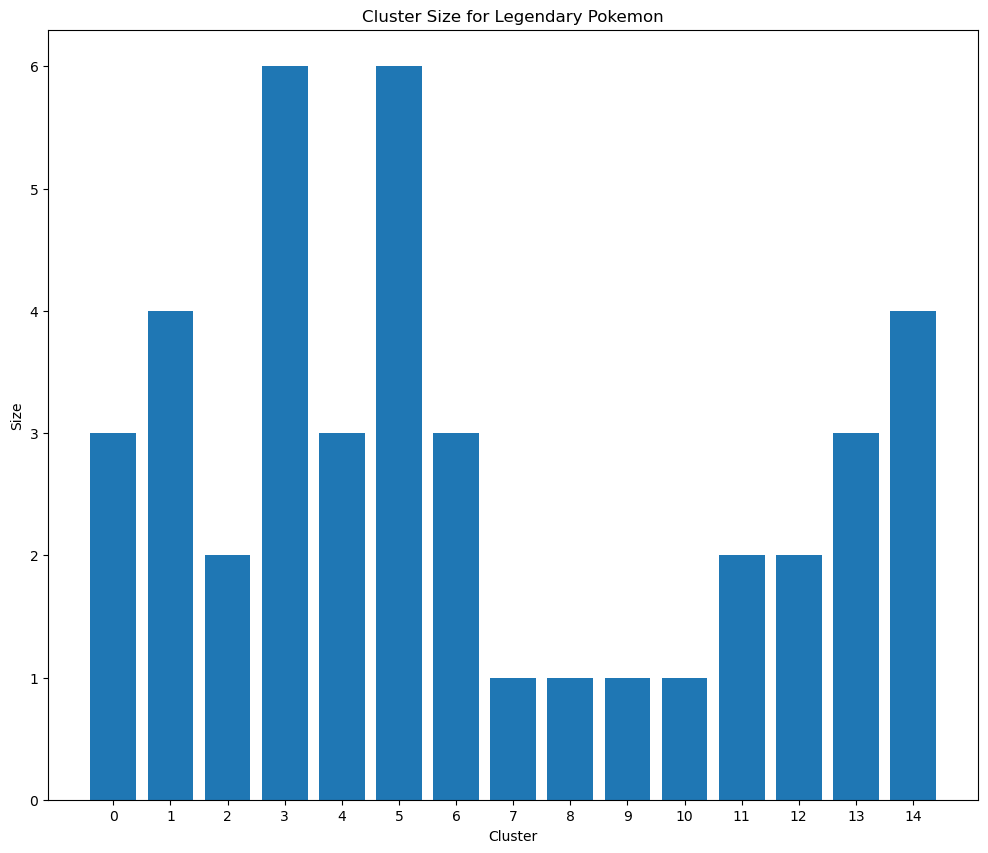

In [68]:
# Makes a copy of the data from above
legendary_df = pokemon_df.copy()

# Filters based on whether it is legendary or not
legendary_df = legendary_df[legendary_df['Legendary']]

# Only use columns with statistics
legendary_df = legendary_df.iloc[:, [1, 4, 5, 6, 7, 8, 9]]

# Get rid of the index and reset it to the name
legendary_df = legendary_df.reset_index()
legendary_df = legendary_df.drop(['index'], axis = 1)
legendary_df = legendary_df.set_index('Name')

# Clustering the data into a specfic amount of clusters
specfic_clusters = sklearn.cluster.KMeans(n_clusters = cluster_slider.value)
specfic_clusters.init = legendary_df.iloc[:cluster_slider.value,:]
cluster_df = specfic_clusters.fit_predict(legendary_df)

# Puts the data into a dataframe
clustered_legendary = pandas.DataFrame(cluster_df, columns = ['Cluster'], index = legendary_df.index)
clustered_legendary = clustered_legendary.sort_values('Cluster')

# Dataframe to show size per cluster
cluster_size = numpy.bincount(clustered_legendary['Cluster'])
cluster_total_df = pandas.DataFrame({'Size': cluster_size})
cluster_total_df = cluster_total_df.reset_index().rename(columns={'index': 'Cluster'})

# Bar chart to show cluster size
fig, ax = plt.subplots(figsize=(12, 10))
plt.bar(cluster_total_df['Cluster'], cluster_total_df['Size'])
plt.xticks(cluster_total_df.index, cluster_total_df.index)
plt.xlabel('Cluster')
plt.ylabel('Size')
plt.title('Cluster Size for Legendary Pokemon')
plt.show

## PCA analysis on legendary Pokemon, PCA

<function matplotlib.pyplot.show(close=None, block=None)>

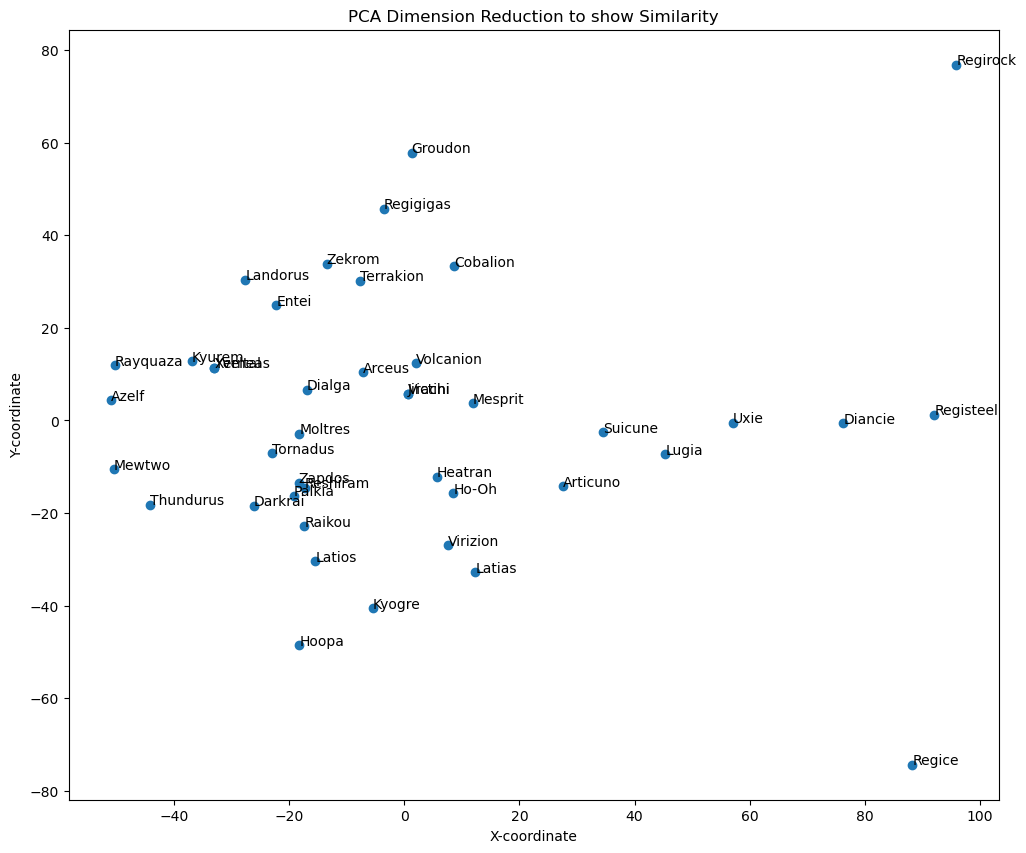

In [69]:
# Now lets find the location of each legendary Pokemon
pca = sklearn.decomposition.PCA(n_components = 2, svd_solver = 'full')
pca_model_data = pca.fit_transform(legendary_df)
pca_df = pandas.DataFrame(pca_model_data, index = legendary_df.index, columns = ['X', 'Y'])
pca_df = pca_df.sort_index()
pca_df = pca_df.reset_index()

# Used to graph
pokemon_names = pca_df.iloc[:, 0].tolist()
x_coords = pca_df.iloc[:, 1].tolist()
y_coords = pca_df.iloc[:, 2].tolist()

# Need to set the X and Y and the names
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(x_coords, y_coords)
for i in range (0, 42):
    ax.text(x_coords[i], y_coords[i], pokemon_names[i])
    
# Labels for the scatter plot
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_title('PCA Dimension Reduction to show Similarity')

# Show the graph
plt.show

# How do different statistics correlate to others all Pokemon, linear regression

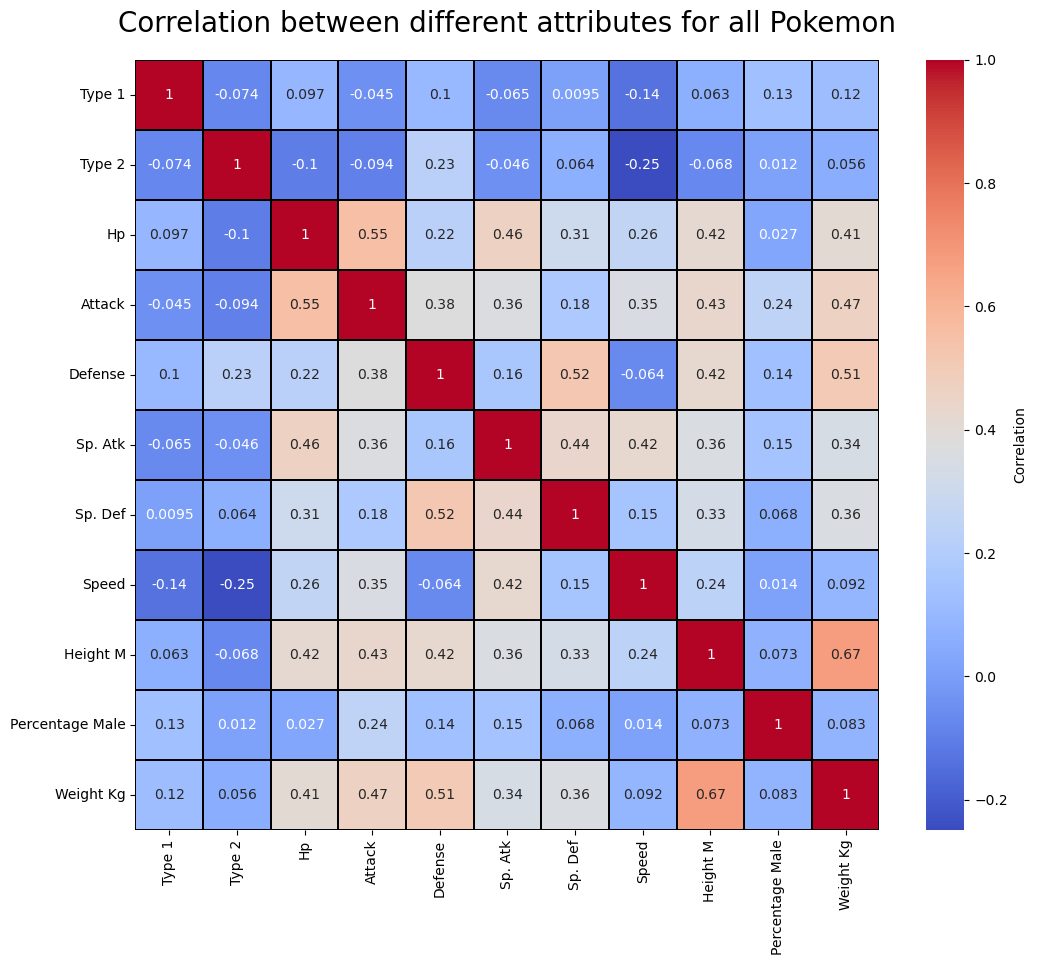

In [17]:
# Need to get rid of the data not being used in this part
corr_stats = pokemon_df.copy()
corr_stats = corr_stats[['Name', 'Type 1', 'Type 2', 'Hp', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height M', 'Percentage Male', 'Weight Kg']]
corr_stats = corr_stats.set_index('Name')

# Get rid of any NaN data in the weight and type 2
corr_stats = corr_stats.dropna(subset = ['Weight Kg', 'Type 2'])

# Encode the string
encode_string = LabelEncoder()
corr_stats['Type 1'] = encode_string.fit_transform(corr_stats['Type 1'])
corr_stats['Type 2'] = encode_string.fit_transform(corr_stats['Type 2'])

# Find correlations between 
corr_fin = corr_stats.corr()
plt.figure(figsize=(12, 10))
plt.title('Correlation between different attributes for all Pokemon', fontsize = 20, pad = 20)
sns.heatmap(corr_fin, annot = True, cmap = 'coolwarm', cbar_kws = {'label': 'Correlation'}, linewidths = 0.25, linecolor = 'black')
plt.show()

# How do different statistics correlate over different generations, linear regression


In [18]:
gen_slider = widgets.IntSlider(value = 1, min = 1, max = 6, step = 1, description = 'Generation:', description_width='auto')
gen_slider.layout.width = '75%'
display(gen_slider)

IntSlider(value=1, description='Generation:', layout=Layout(width='75%'), max=6, min=1)

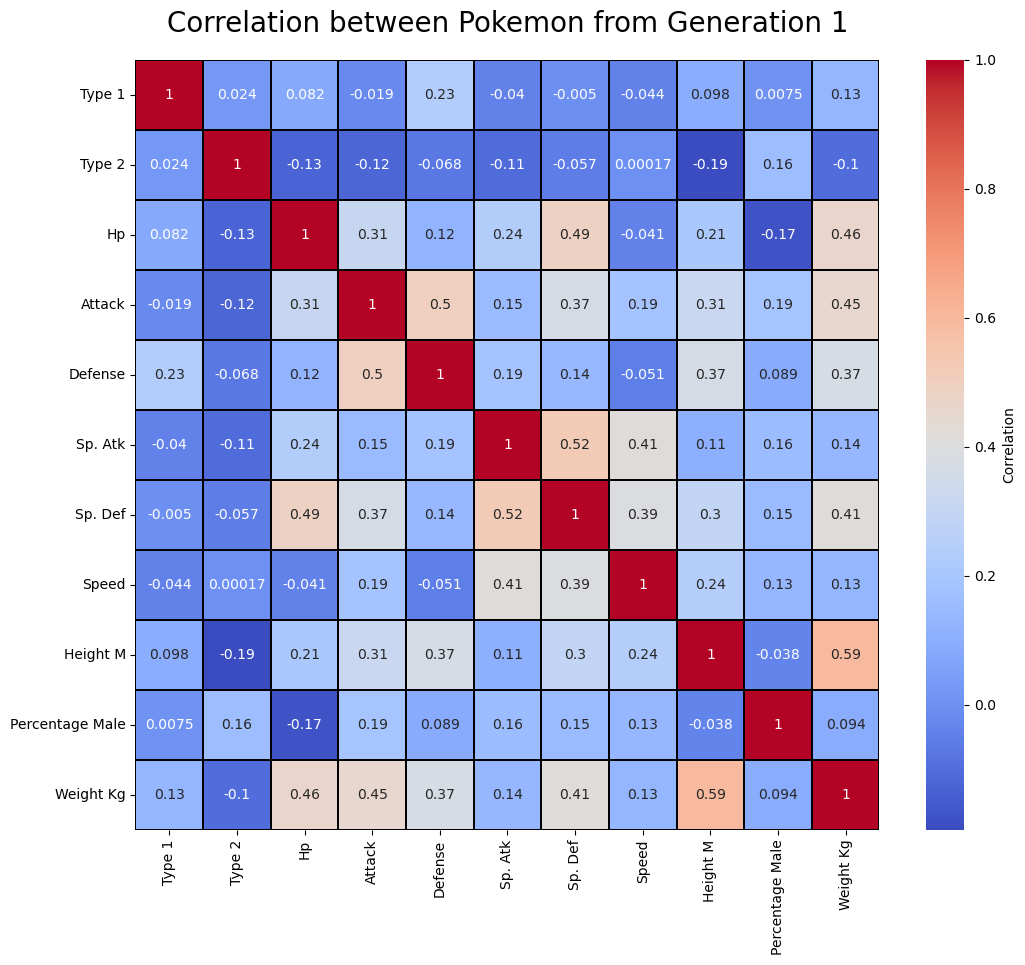

In [19]:
# Create a copy to not mess up previous dataset
generation_df = pokemon_df.copy()

# Only allows Pokemon from that generation
generation_df = generation_df[generation_df['Generation'] == gen_slider.value]
generation_corr_stats = generation_df[['Name', 'Type 1', 'Type 2', 'Hp', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height M', 'Percentage Male', 'Weight Kg']]
generation_corr_stats = generation_corr_stats.set_index('Name')

# Encode the string
encode_string = LabelEncoder()
generation_corr_stats['Type 1'] = encode_string.fit_transform(generation_corr_stats['Type 1'])
generation_corr_stats['Type 2'] = encode_string.fit_transform(generation_corr_stats['Type 2'])

# Find the correlation matrix
generation_corr_fin = generation_corr_stats.corr()

# Graph it
plt.figure(figsize=(12, 10))
plt.title('Correlation between Pokemon from Generation ' + str(gen_slider.value), fontsize = 20, pad = 20)
sns.heatmap(generation_corr_fin, annot = True, cmap = 'coolwarm', cbar_kws = {'label': 'Correlation'}, linewidths = 0.25, linecolor = 'black')
plt.show()

## Visualizing distance matrix of legendary Pokemon, euclidean distances

In [ ]:
# Find the euclidean distance for each legendary Pokemon and store it 
euc_dist_matrix = sklearn.metrics.pairwise.euclidean_distances(legendary_df)
euc_dist_matrix = pandas.DataFrame(euc_dist_matrix, index = legendary_df.index, columns = legendary_df.index)

euc_dist_matrix